In [ ]:
import numpy as np
import tensorflow as tf
import os, keras, cv2
import pandas as pd
import matplotlib.pyplot as plt

# **Dataset**

In [ ]:
# unzip Data
!unzip Images.zip
!unzip Annotations.zipAnnotations.zip8

In [ ]:
#visualization 
# select image name
file_name = 'airplane_440'

# read image
img = cv2.imread(os.path.join('./Images', file_name + '.jpg'))

# read CSV File
df = pd.read_csv(os.path.join('./Airplanes_Annotations/', file_name + '.csv'))

# iterate and read bounding box
for i, row in df.iterrows():
  temp_data = row.item()
  x1 = int(temp_data.split(" ")[0])
  y1 = int(temp_data.split(" ")[1])
  x2 = int(temp_data.split(" ")[2])
  y2 = int(temp_data.split(" ")[3])
  cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)

plt.figure()
plt.imshow(img);

# **Intersection of Union**

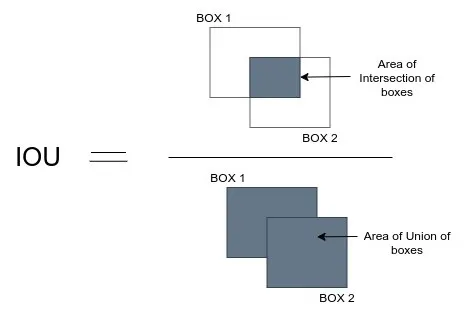

In [ ]:
# calculate IOU
def iou_calc(box_1, box_2):
    # coordinate of intersection
    x_left = max(box_1['x1'], box_2['x1'])
    y_top = max(box_1['y1'], box_2['y1'])
    x_right = min(box_1['x2'], box_2['x2'])
    y_bottom = min(box_1['y2'], box_2['y2'])

    # check zero intersection area
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    box1_area = (box_1['x2'] - box_1['x1']) * (box_1['y2'] - box_1['y1'])
    box2_area = (box_2['x2'] - box_2['x1']) * (box_2['y2'] - box_2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

In [ ]:
# test iou
print(iou_calc({"x1":20,"x2":40,"y1":30,"y2":50}, {"x1":20,"x2":40,"y1":30,"y2":50}))
print(iou_calc({"x1":20,"x2":40,"y1":30,"y2":50}, {"x1":25,"x2":30,"y1":20,"y2":60}))
print(iou_calc({"x1":20,"x2":40,"y1":30,"y2":50}, {"x1":45,"x2":70,"y1":50,"y2":60}))

# **Selective Search**
It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

In [ ]:
# create object fron opencv selective search class
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
img = cv2.imread(os.path.join('./Images',"airplane_440.jpg"))

# set image for selective search algorithm
ss.setBaseImage(img)

# set parameters of ss algorithm
ss.switchToSelectiveSearchFast()

# get bounding boxes from ss algorithm
rects = ss.process()

# draw and show results
for i, rect in (enumerate(rects[:100])):
    x, y, w, h = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.imshow(img);

# **Data Generator**

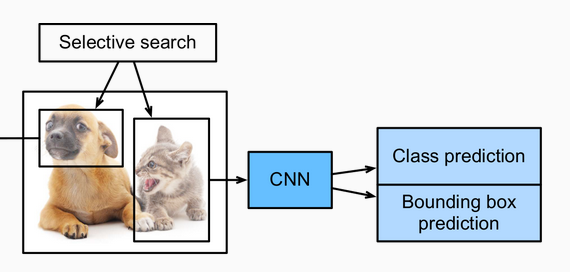

In [ ]:

import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_names, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=2, shuffle=False, img_path='./', annot_path='./'):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_names = list_names
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.img_path = img_path
        self.annot_path = annot_path

    # get length of data generator
    def __len__(self):
        return int(np.floor(len(self.list_names) / self.batch_size))

    # get images and related tags 
    def __getitem__(self, index):
        indexes = self.list_names[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y


    # generate cropped images and set appropriate label for images
    def __data_generation(self, indexes):

        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        # Initialization
        X = np.zeros((self.batch_size * 100, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * 100))

        # Generate data
        for i, ID in enumerate(indexes):
            i = i * 100

            image = cv2.imread(os.path.join(self.img_path,ID))
            df = pd.read_csv(os.path.join(self.annot_path,ID.split(".")[0]+".csv"))

            # save ground truth 
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

            # generate bounding boxes with ss algorithm
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            img_out = image.copy()
            plane_cnt  = 0
            background_cnt = 0

            for e,result in enumerate(ssresults):
                for gtval in gtvalues:
                    if plane_cnt + background_cnt < 100 :
                        x,y,w,h = result

                        # calculate IOU
                        iou = iou_calc(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        # check number of plane images
                        if plane_cnt < 80:
                            # check IOU
                            if iou > 0.70:
                                # crop image
                                timage = img_out[y:y+h,x:x+w]
                                # resize image
                                resized = cv2.resize(timage, self.dim, interpolation = cv2.INTER_AREA)
                                X[i+ plane_cnt+ background_cnt,] = resized
                                # set label 1 for plane image
                                Y[i+ plane_cnt+ background_cnt] = 1
                                plane_cnt += 1

                        # check number of background images
                        if background_cnt <80:
                            # check IOU
                            if iou < 0.3:
                                # crop image
                                timage = img_out[y:y+h,x:x+w]
                                # resize image
                                resized = cv2.resize(timage, self.dim, interpolation = cv2.INTER_AREA)
                                X[i+ plane_cnt+ background_cnt,] = resized
                                # set label 0 for background image
                                Y[i+ plane_cnt+ background_cnt] = 0
                                background_cnt += 1
    


        return X, keras.utils.to_categorical(Y, num_classes=self.n_classes)

In [ ]:
import os
# get names of image
list_names = os.listdir('/content/Images')
# create train generator and validation generator
training_generator = DataGenerator(list_names = list_names[:100], batch_size = 1, img_path= '/content/Images', annot_path = '/content/Airplanes_Annotations')
validation_generator = DataGenerator(list_names = list_names[100:120], batch_size = 1, img_path= '/content/Images', annot_path = '/content/Airplanes_Annotations')

In [ ]:
X, Y = validation_generator.__getitem__(19)

In [ ]:
plt.imshow(X[85].astype(int));

In [ ]:
Y[85]

# **Model- Fine tuning**

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
# load VGG16 pretrained model
vggmodel = VGG16(weights='imagenet')
vggmodel.summary()

In [ ]:
# extract all layers excluding the last one 
X= vggmodel.layers[-2].output

# create Dense layer with 2 outputs
predictions = Dense(2, activation="softmax")(X)

# concatanate and create final model
model = Model(inputs = vggmodel.input, outputs = predictions)

In [ ]:
model.summary()

In [ ]:
from keras.optimizers import Adam

# create Adam optimizer
opt = Adam(learning_rate=0.0001)

# compile model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
# train model
hist = model.fit(x= training_generator, batch_size=1, epochs= 10, validation_data= validation_generator)

In [ ]:
import matplotlib.pyplot as plt

# plot loss and accuracy 

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

# **Model - From Scratch**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

# create model from scratch
model = Sequential()

# convolutional layers
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(224, 224, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())

# fully conected layers
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.35))
model.add(Dense(2, activation="softmax"))

In [ ]:
from keras.optimizers import Adam

# create Adam optimizer
opt = Adam(learning_rate=0.0001)

# compile model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
# train model
hist = model.fit(x= training_generator, batch_size=1, epochs= 10, validation_data= validation_generator)

# **Inferencing**

In [ ]:
# read image
img = cv2.imread(os.path.join('/content/Images','airplane_007.jpg'))

# get ss algorith's bounding boxes
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
img_out = img.copy()

for i, result in enumerate(ssresults):
    if i < 2000:
        x,y,w,h = result
        # crop image (area that ss algorithm suggested)
        img_crop = img_out[y:y+h,x:x+w]
        # resize image
        resized = cv2.resize(img_crop, (224,224), interpolation = cv2.INTER_AREA)
        # add one dimension at the 0 axis for batch
        img = np.expand_dims(resized, axis=0)
        # get results from model
        out= model.predict(img)
        # check confidence
        if out[0][1] > 0.55:
            cv2.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

# plot final image  
plt.figure()
plt.imshow(img_out);